a faire:
-data annotation (rectangle) roboflow
-data augmentation (RandomResizedCrop, HorizontalFlip, VerticalFlip, RandomRotation, ColorJitter, Normalize) train set/ val set
-model training


Model1: partie segmentation:

idee chat: cnn ou unet
CNN + Regression	Predict counts directly from full image	If chocolates are big and well separated ATT: If chocolates are very close visually (small differences between classes), CNN may confuse them unless you augment a lot and train carefully.
UNet + Segmentation	Predict pixel masks and count blobs	If chocolates are small, many, or clustered


uNet: SI ON ANNOTE MANUELLEMENT DES MAKS
Encoder (downsampling path):

Conv2d(3 → 16), ReLU, MaxPool

Conv2d(16 → 32), ReLU, MaxPool

Conv2d(32 → 64), ReLU, MaxPool

Bottleneck:

Conv2d(64 → 128), ReLU

Decoder (upsampling path):

Upsample, Conv2d(128 → 64), ReLU

Upsample, Conv2d(64 → 32), ReLU

Upsample, Conv2d(32 → 16), ReLU

Output:

Conv2d(16 → 13), no activation (logits).

During training:

Apply softmax on output.

Use CrossEntropyLoss (for pixel-wise classification among 13 chocolate classes).

During inference:

Apply argmax across 13 channels → assign most probable class per pixel.

In [ ]:
import os
print(os.getcwd())
!cd drive


/content/drive_mount/MyDrive/Colab Notebooks/project
/bin/bash: line 1: cd: drive: No such file or directory


In [51]:
from google.colab import drive
import os

# Use a unique/new mount point
mount_path = "/content/drive_mount"
drive.mount(mount_path)

# Then move to your working directory
os.chdir(f"{mount_path}/MyDrive/Colab Notebooks/project")
print(os.getcwd())

Drive already mounted at /content/drive_mount; to attempt to forcibly remount, call drive.mount("/content/drive_mount", force_remount=True).
/content/drive_mount/MyDrive/Colab Notebooks/project


In [52]:
import json
import os
import numpy as np
from PIL import Image, ImageDraw
from tqdm import tqdm

print(os.getcwd())
# Paths
json_path = "/content/drive_mount/MyDrive/Colab Notebooks/project/dataset_project_iapr2025/train_annotated/train/_annotations.coco.json"
output_mask_dir = "/content/drive_mount/MyDrive/Colab Notebooks/project/dataset_project_iapr2025/train_annotated/train/train_mask"
os.makedirs(output_mask_dir, exist_ok=True)
'''# --- Load COCO JSON ---
with open(json_path, "r") as f:
    coco = json.load(f)

# Map image_id → image info
image_id_to_info = {img["id"]: img for img in coco["images"]}

# Manually build image_id → list of annotations
image_id_to_annotations = {}
for ann in coco["annotations"]:
    img_id = ann["image_id"]
    if img_id not in image_id_to_annotations:
        image_id_to_annotations[img_id] = []
    image_id_to_annotations[img_id].append(ann)

# --- Generate mask per image ---
for image_id in tqdm(image_id_to_annotations, desc="Generating circular masks"):
    img_info = image_id_to_info[image_id]
    width, height = img_info["width"], img_info["height"]
    mask = Image.new("L", (width, height), 0)
    draw = ImageDraw.Draw(mask)

    for ann in image_id_to_annotations[image_id]:
        bbox = ann["bbox"]
        x_center = bbox[0] + bbox[2] // 2
        y_center = bbox[1] + bbox[3] // 2
        fixed_radius=290
        draw.ellipse(
            (x_center - fixed_radius, y_center - fixed_radius, x_center + fixed_radius, y_center + fixed_radius),
            fill=255
        )

    # Save final mask
    base_name = os.path.splitext(img_info["file_name"])[0]
    mask.save(os.path.join(output_mask_dir, f"{base_name}_mask.png"))'''
'''
# --- Load COCO JSON ---
with open(json_path, "r") as f:
    coco = json.load(f)

# Map image_id → image info
image_id_to_info = {}
for img in coco["images"]:
    image_id_to_info[img["id"]] = img

# Manually build image_id → list of annotations
image_id_to_annotations = {}
for ann in coco["annotations"]:
    img_id = ann["image_id"]
    if img_id not in image_id_to_annotations:
        image_id_to_annotations[img_id] = []
    image_id_to_annotations[img_id].append(ann)

# --- Generate mask per image ---
for image_id in tqdm(image_id_to_annotations, desc="Generating masks"):
    img_info = image_id_to_info[image_id]
    width, height = img_info["width"], img_info["height"]
    mask = Image.new("L", (width, height), 0)
    draw = ImageDraw.Draw(mask)

    for ann in image_id_to_annotations[image_id]:
        segmentation = ann.get("segmentation", [])
        if isinstance(segmentation, list):  # Only process polygon-type
            for polygon in segmentation:
                points = [(polygon[i], polygon[i + 1]) for i in range(0, len(polygon), 2)]
                draw.polygon(points, fill=255)

    # Save final mask
    base_name = os.path.splitext(img_info["file_name"])[0]
    mask.save(os.path.join(output_mask_dir, f"{base_name}_mask.png"))
'''


/content/drive_mount/MyDrive/Colab Notebooks/project


'\n# --- Load COCO JSON ---\nwith open(json_path, "r") as f:\n    coco = json.load(f)\n\n# Map image_id → image info\nimage_id_to_info = {}\nfor img in coco["images"]:\n    image_id_to_info[img["id"]] = img\n\n# Manually build image_id → list of annotations\nimage_id_to_annotations = {}\nfor ann in coco["annotations"]:\n    img_id = ann["image_id"]\n    if img_id not in image_id_to_annotations:\n        image_id_to_annotations[img_id] = []\n    image_id_to_annotations[img_id].append(ann)\n\n# --- Generate mask per image ---\nfor image_id in tqdm(image_id_to_annotations, desc="Generating masks"):\n    img_info = image_id_to_info[image_id]\n    width, height = img_info["width"], img_info["height"]\n    mask = Image.new("L", (width, height), 0)\n    draw = ImageDraw.Draw(mask)\n\n    for ann in image_id_to_annotations[image_id]:\n        segmentation = ann.get("segmentation", [])\n        if isinstance(segmentation, list):  # Only process polygon-type\n            for polygon in segmentat

In [53]:
#smaller unet
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = conv_block(256, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = conv_block(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        b = self.bottleneck(self.pool(e3))

        d3 = self.dec3(torch.cat([self.up3(b), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return torch.sigmoid(self.final(d1))


In [54]:
model = UNet()
total_params = sum(p.numel() for p in model.parameters())
total_params

7702977

In [55]:
#class dataset + transform :
import os
import random
import numpy as np
from PIL import Image
from scipy.ndimage import gaussian_filter, map_coordinates
from PIL import ImageFilter
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T
import torchvision.transforms.functional as TF


def elastic_transform(image, alpha, sigma, random_state=None):
    """Elastic deformation of an image (NumPy array)."""
    if random_state is None:
        random_state = np.random.RandomState(None)

    image_np = np.array(image)

    shape = image_np.shape[:2]
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1))

    if image_np.ndim == 3:
        channels = [map_coordinates(image_np[..., c], indices, order=1, mode='reflect').reshape(shape) for c in range(image_np.shape[2])]
        distorted = np.stack(channels, axis=-1)
    else:
        distorted = map_coordinates(image_np, indices, order=1, mode='reflect').reshape(shape)

    return Image.fromarray(np.uint8(distorted))

def random_cutout(image, mask, num_holes=3, max_size=40):
    """
    Apply random black square cutouts to both image and mask.
    Only image is altered visually; mask is left unchanged.
    """
    w, h = image.size

    for _ in range(num_holes):
        cutout_w = random.randint(10, max_size)
        cutout_h = random.randint(10, max_size)
        x0 = random.randint(0, w - cutout_w)
        y0 = random.randint(0, h - cutout_h)

        # Draw a black rectangle on the image
        image.paste((0, 0, 0), (x0, y0, x0 + cutout_w, y0 + cutout_h))

        # Optional: zero out same region in the mask (if wanted)
        # mask.paste(0, (x0, y0, x0 + cutout_w, y0 + cutout_h))

    return image, mask
def add_random_noise(img, noise_level=0.05):
    """Add Gaussian noise to a PIL image."""
    np_img = np.array(img).astype(np.float32) / 255.0
    noise = np.random.normal(0, noise_level, np_img.shape)
    noisy_img = np.clip(np_img + noise, 0, 1)
    noisy_img = (noisy_img * 255).astype(np.uint8)
    return Image.fromarray(noisy_img)


class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, size=(256, 256), augmentations=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.size = size


        base_images = [img for img in os.listdir(image_dir)
                       if img.endswith(('.jpg', '.png')) and os.path.exists(
                           os.path.join(mask_dir, os.path.splitext(img)[0] + "_mask.png"))]

        # Transform for image only
        self.image_only_transform = T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05)

        # Common resize transform
        self.resize = T.Resize(size)

        self.available_augmentations = {
                    "hflip": lambda img, msk: (TF.hflip(img), TF.hflip(msk)),
                    "vflip": lambda img, msk: (TF.vflip(img), TF.vflip(msk)),
                    "rotation": lambda img, msk: (TF.rotate(img, angle := random.uniform(-15, 15)), TF.rotate(msk, angle)),
                    "rotation2": lambda img, msk: (TF.rotate(img, angle := random.uniform(-45, 45)), TF.rotate(msk, angle)),
                    "color_jitter": lambda img, msk: (T.ColorJitter(0.2, 0.2, 0.2, 0.05)(img), msk),
                    "blur": lambda img, msk: (img.filter(ImageFilter.GaussianBlur(random.uniform(0.5, 1.5))), msk),
                    "elastic": lambda img, msk: (elastic_transform(img, alpha=20, sigma=4), elastic_transform(msk, alpha=20, sigma=4)),
                    "cutout": lambda img, msk: random_cutout(img, msk, num_holes=10, max_size=30),
                    "cutout2": lambda img, msk: random_cutout(img, msk, num_holes=3, max_size=120),
                    "cutout3": lambda img, msk: random_cutout(img, msk, num_holes=50, max_size=20),
                    "random_noise": lambda img, msk: (add_random_noise(img), msk),
                }

        self.augmentations = augmentations if augmentations else []

        # Store each (image_name, augmentation_name)
        self.samples = []
        if augmentations:
            for img in base_images:
                self.samples.append((img, None))
                for aug_name, prob in augmentations:
                    if random.random() < prob:
                        self.samples.append((img, aug_name))  # Only include if probability passes

        else:
            for img in base_images:
                self.samples.append((img, None))  # no augmentation

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_name, aug_name = self.samples[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, os.path.splitext(img_name)[0] + "_mask.png")

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        image = self.resize(image)
        mask = self.resize(mask)

        for aug_name, prob in self.augmentations:
            if random.random() < prob and aug_name in self.available_augmentations:
                image, mask = self.available_augmentations[aug_name](image, mask)


        image = T.ToTensor()(image)
        mask = T.ToTensor()(mask)
        mask = (mask > 0.5).float()  # Binarize

        return image, mask



In [36]:

import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import ToPILImage
from PIL import Image
import os

def show_all_augmentations(dataset, idx=0):
    """
    Visualize one example of each individual augmentation applied to a single image.
    """
    to_pil = ToPILImage()

    # Get base image name (without augmentation)
    if hasattr(dataset, "samples"):
        img_name = dataset.samples[idx][0] if isinstance(dataset.samples[idx], tuple) else dataset.samples[idx]
    else:
        img_name = dataset.images[idx]
    img_path = os.path.join(dataset.image_dir, img_name)
    mask_path = os.path.join(dataset.mask_dir, os.path.splitext(img_name)[0] + "_mask.png")

    # Load and resize image and mask
    image = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path).convert("L")

    image = dataset.resize(image)
    mask = dataset.resize(mask)

    aug_names = list(dataset.available_augmentations.keys())
    n_aug = len(aug_names)

    fig, axs = plt.subplots(n_aug, 2, figsize=(8, 3 * n_aug))
    fig.suptitle("One Sample per Augmentation Type", fontsize=18)

    if n_aug == 1:
        axs = [axs]  # ensure axs is iterable in case of single augmentation

    for i, aug_name in enumerate(aug_names):
        img_aug, mask_aug = dataset.available_augmentations[aug_name](image.copy(), mask.copy())

        axs[i][0].imshow(to_pil(T.ToTensor()(img_aug)))
        axs[i][0].set_title(f"Image: {aug_name}")
        axs[i][0].axis("off")

        axs[i][1].imshow(np.array(mask_aug), cmap='gray')
        axs[i][1].set_title(f"Mask: {aug_name}")
        axs[i][1].axis("off")

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()




In [37]:
path = "/content/drive/MyDrive/Colab Notebooks/project"

Dataset size: 900


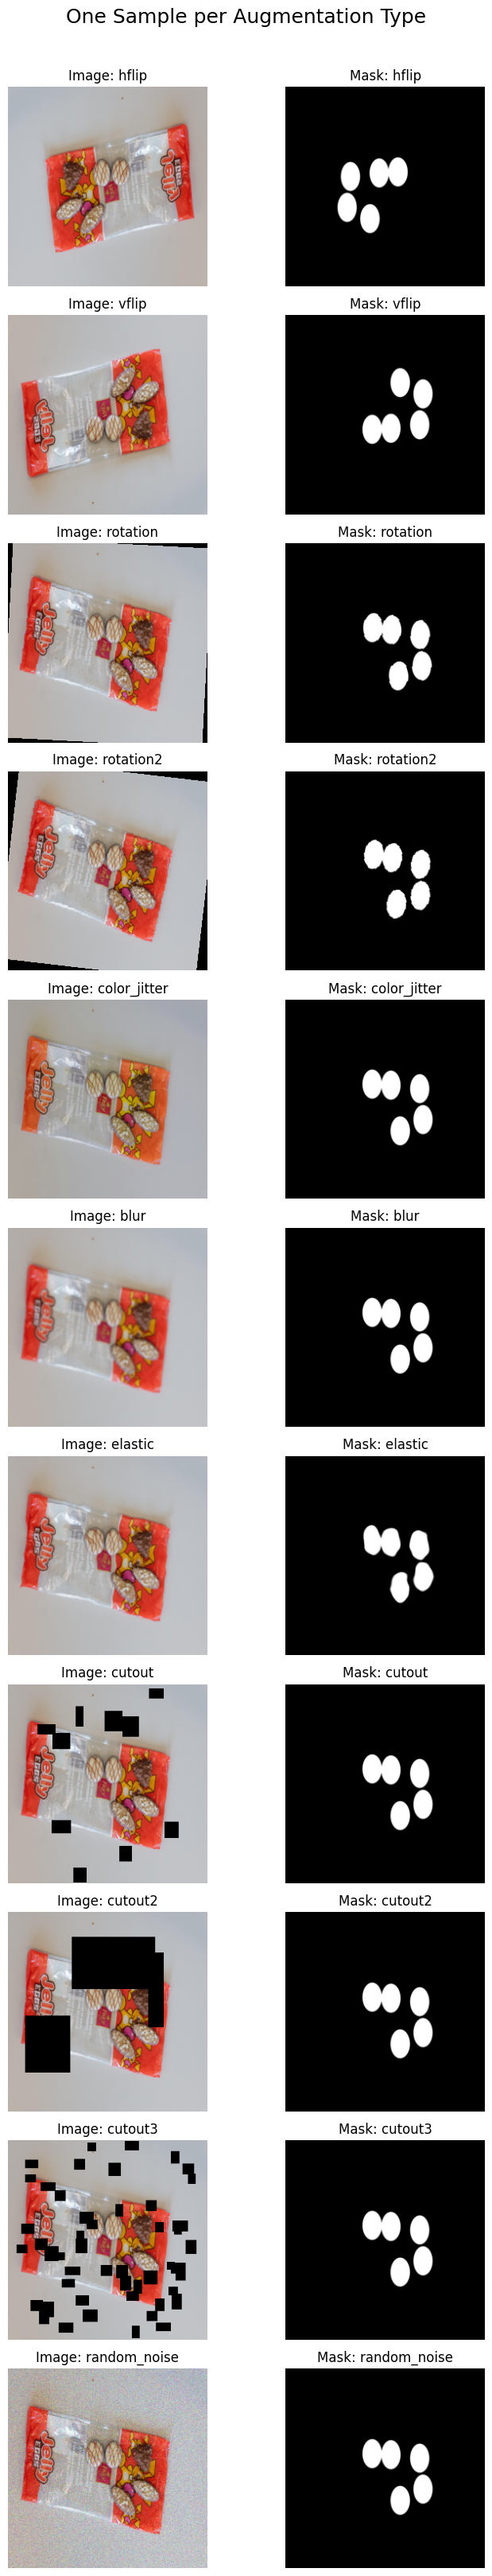

In [56]:
dataset_augmented = SegmentationDataset(
    image_dir="dataset_project_iapr2025/train_annotated/train",
    mask_dir="dataset_project_iapr2025/train_annotated/train/train_mask",
    size=(256, 256),
    augmentations=[
        ("hflip", 1),
        ("vflip", 1),
        ("rotation", 1),
        ("color_jitter", 1),
        ("blur", 1),
        ("elastic", 1),
        ("cutout", 1),
        ("cutout2", 1),
        ("cutout3", 1),
    ]
)
print(f"Dataset size: {len(dataset_augmented)}")

show_all_augmentations(dataset_augmented, idx=400) # idx * 8 car ca compte lees transfo


les 2 cutout: ("cutout", 0.5),
        ("cutout2", 0.5), est vrm surprenament bon sauf pour chocolat blanc, 15 epoch

In [77]:
from torch.utils.data import DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim

epochs = 25
lr = 1e-3
batch_size = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset_augmented = SegmentationDataset(
    image_dir="dataset_project_iapr2025/train_annotated/train",
    mask_dir="dataset_project_iapr2025/train_annotated/train/train_mask",
    size=(256, 256),
    augmentations=[
        ("hflip", 0.1),
        ("vflip", 0.1),
        ("rotation", 0.3),
        ("color_jitter", 0.1),
        ("blur", 0.1),
        ("elastic", 0.2),
        ("cutout", 0.5),
        ("cutout2", 0.5),
    ]
)
loader = DataLoader(dataset_augmented, batch_size=batch_size, shuffle=True)

# Model, Loss, Optimizer
model = UNet().to(device)
criterion = nn.BCELoss()
#criterion = lambda pred, target: nn.BCELoss()(pred, target) + DiceLoss()(pred, target)
#criterion = OverSegmentationLoss(alpha=1.0, beta=5.0)
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training Loop
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device)

        preds = model(images)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(loader):.4f}")

    # Save the model every 5 epochs, starting from epoch 5 (i.e., epoch index 4)
    if (epoch + 1) % 5 == 0:
        save_path = f"Bon_mask_model4_epoch{epoch+1}.pth"
        torch.save(model.state_dict(), save_path)
        print(f"Model saved at '{save_path}'")

torch.save(model.state_dict(), "Bond_mask_model4.pth")
print("Model saved as 'bon_mask_model3.pth'")

Epoch 1/25 - Loss: 0.3280
Epoch 2/25 - Loss: 0.1683
Epoch 3/25 - Loss: 0.1311
Epoch 4/25 - Loss: 0.1078
Epoch 5/25 - Loss: 0.1029
Model saved at 'Bon_mask_model4_epoch5.pth'
Epoch 6/25 - Loss: 0.1001
Epoch 7/25 - Loss: 0.0916
Epoch 8/25 - Loss: 0.0820
Epoch 9/25 - Loss: 0.0745
Epoch 10/25 - Loss: 0.0725
Model saved at 'Bon_mask_model4_epoch10.pth'
Epoch 11/25 - Loss: 0.0718
Epoch 12/25 - Loss: 0.0658
Epoch 13/25 - Loss: 0.0693
Epoch 14/25 - Loss: 0.0632
Epoch 15/25 - Loss: 0.0639
Model saved at 'Bon_mask_model4_epoch15.pth'
Epoch 16/25 - Loss: 0.0574
Epoch 17/25 - Loss: 0.0560
Epoch 18/25 - Loss: 0.0604
Epoch 19/25 - Loss: 0.0557
Epoch 20/25 - Loss: 0.0547
Model saved at 'Bon_mask_model4_epoch20.pth'
Epoch 21/25 - Loss: 0.0527
Epoch 22/25 - Loss: 0.0488
Epoch 23/25 - Loss: 0.0526
Epoch 24/25 - Loss: 0.0479
Epoch 25/25 - Loss: 0.0495
Model saved at 'Bon_mask_model4_epoch25.pth'
Model saved as 'bon_mask_model3.pth'


In [39]:
'''# Save final model
torch.save(model.state_dict(), "unet_final9.pth")
print("Model saved as 'unet_final9.pth'")
'''

'# Save final model\ntorch.save(model.state_dict(), "unet_final9.pth")\nprint("Model saved as \'unet_final9.pth\'")\n'

In [57]:

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Total parameters: 7,702,977
Trainable parameters: 7,702,977


In [58]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

def load_test_image(image_path, size=(256, 256)):
    image = Image.open(image_path).convert("RGB").resize(size)
    transform = transforms.ToTensor()
    image_tensor = transform(image).unsqueeze(0)  # shape: [1, 3, H, W]
    return image_tensor, image


In [59]:
def predict_mask(model, image_tensor, threshold=0.5):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        output = model(image_tensor)
        pred_mask = (output.squeeze(0).squeeze(0) > threshold).float().cpu()
    return pred_mask


In [60]:
def show_result(original_img, pred_mask):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(pred_mask, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


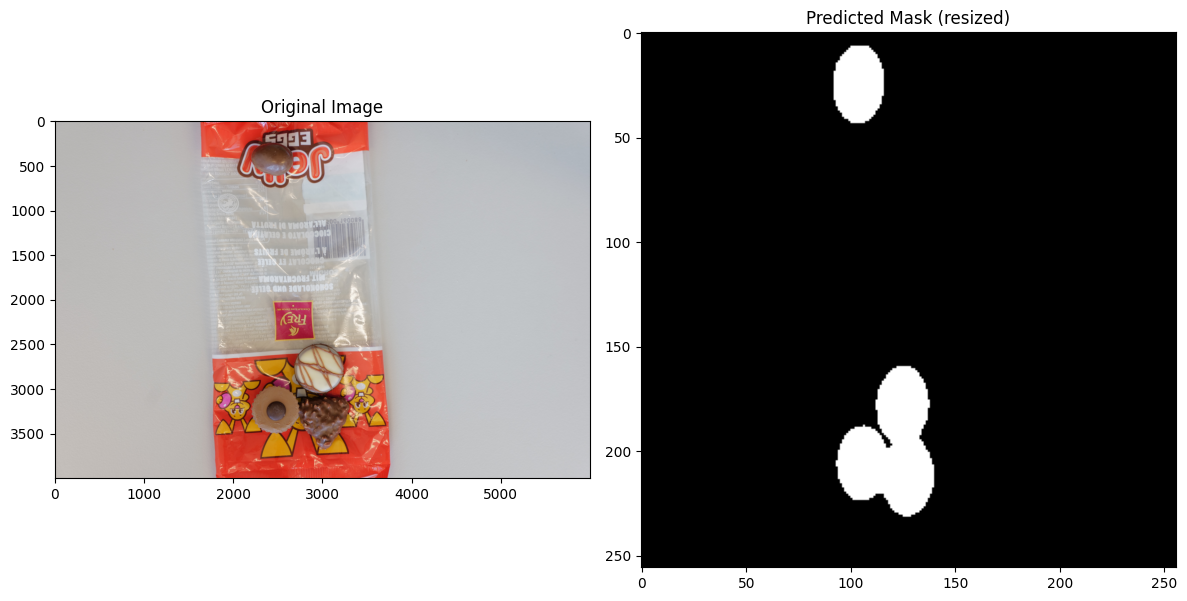

In [99]:
# Replace with your test image path L1010030
test_image_path = "dataset_project_iapr2025/test/L1000915.JPG"

#Load model (if starting fresh)
model = UNet().to(device)
model.load_state_dict(torch.load("Bon_mask_model4_epoch25.pth", map_location=device))

# Inference
image_tensor, original_img = load_test_image(test_image_path, size=(256, 256))
predicted_mask = predict_mask(model, image_tensor)
show_result(original_img, predicted_mask)


/content/drive_mount/MyDrive/Colab Notebooks/project/dataset_project_iapr2025/test/L1000800.JPG


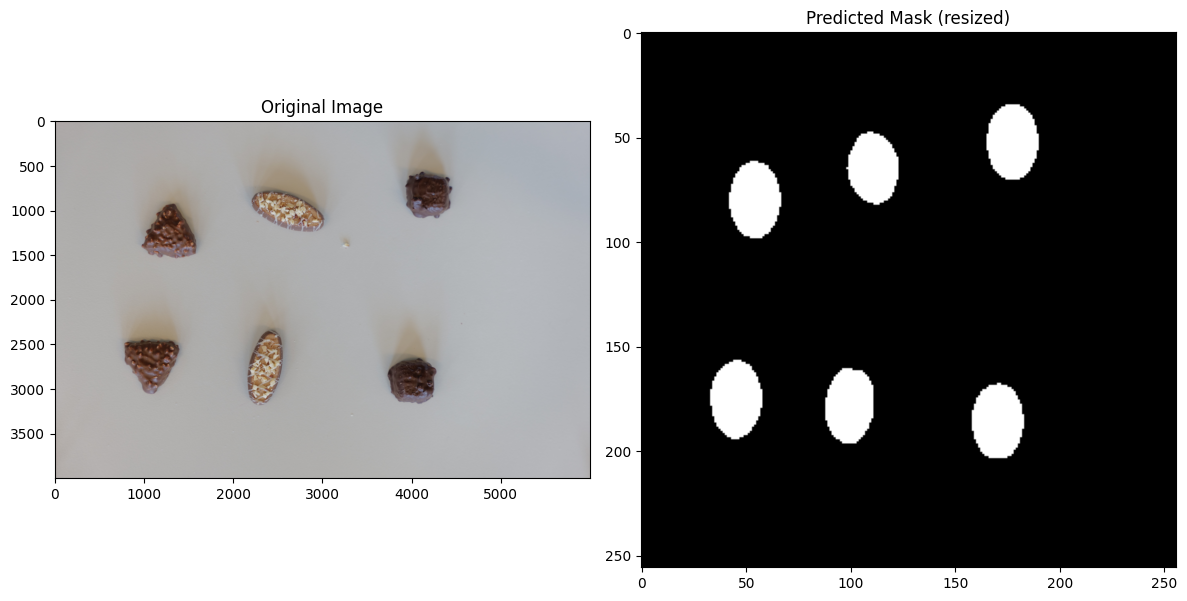

In [100]:
# Replace with your test image path
test_image_path = os.path.join(os.getcwd(),"dataset_project_iapr2025/test/L1000800.JPG")
print(test_image_path)
image_tensor, original_img = load_test_image(test_image_path, size=(256, 256))
predicted_mask = predict_mask(model, image_tensor)
show_result(original_img, predicted_mask)

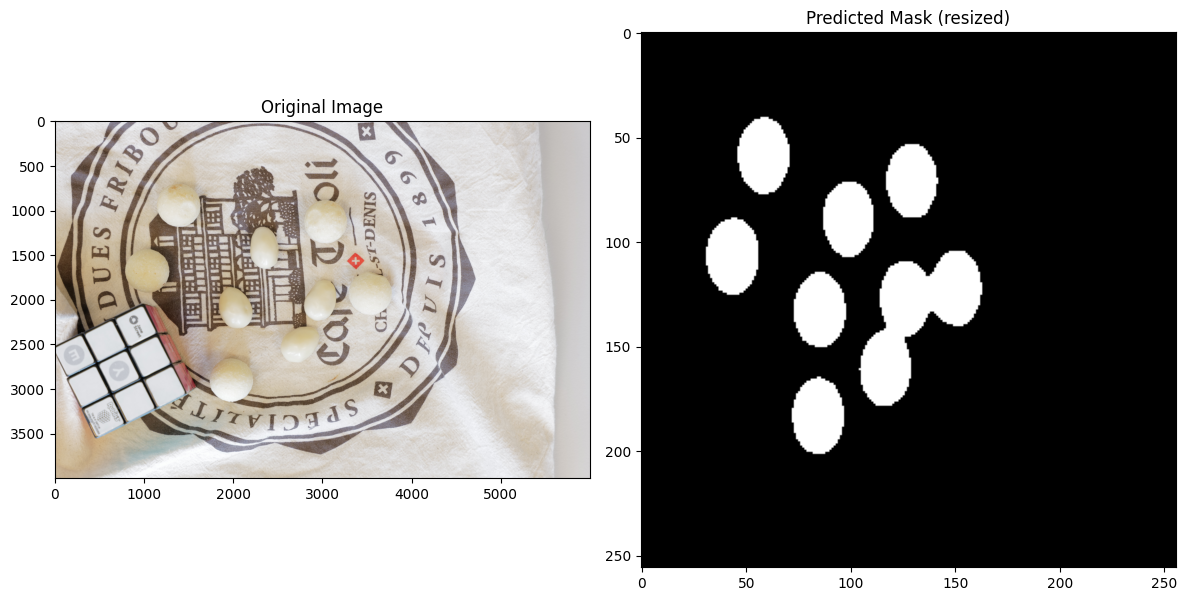

In [101]:

# Replace with your test image path
test_image_path = "dataset_project_iapr2025/test/L1010038.JPG"

# Load model (if starting fresh)
'''model = UNet().to(device)
model.load_state_dict(torch.load("unet_checkpoint.pth", map_location=device))'''

# Inference
image_tensor, original_img = load_test_image(test_image_path, size=(256, 256))
predicted_mask = predict_mask(model, image_tensor)
show_result(original_img, predicted_mask)

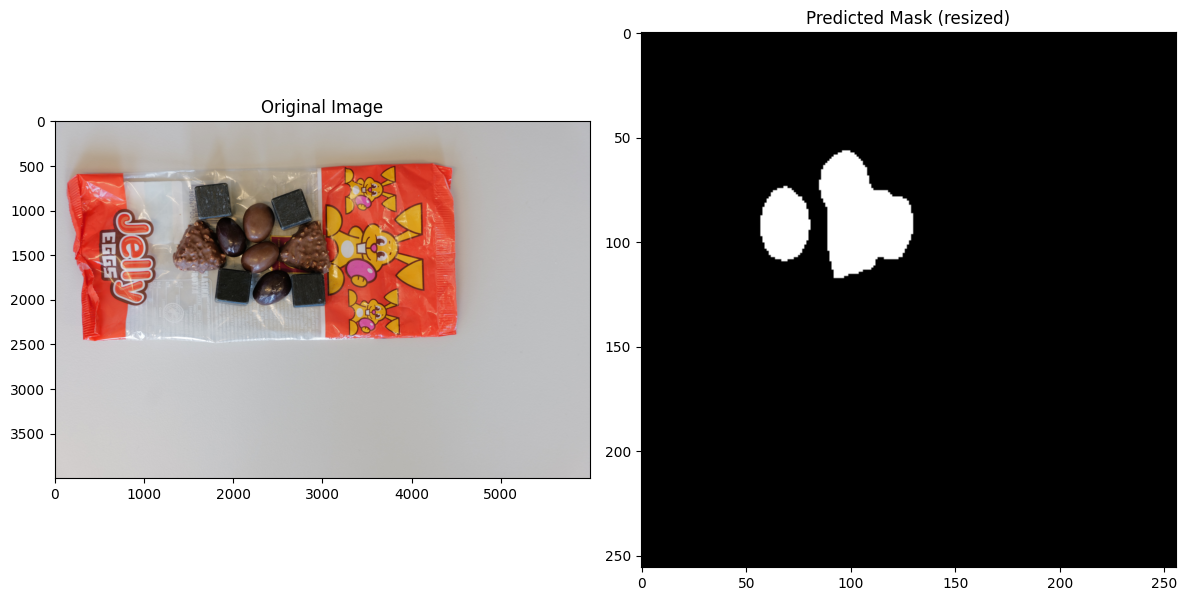

In [102]:

# Replace with your test image path
test_image_path = "dataset_project_iapr2025/test/L1010044.JPG"

# Load model (if starting fresh)
'''model = UNet().to(device)
model.load_state_dict(torch.load("unet_checkpoint.pth", map_location=device))'''

# Inference
image_tensor, original_img = load_test_image(test_image_path, size=(256, 256))
predicted_mask = predict_mask(model, image_tensor)
show_result(original_img, predicted_mask)

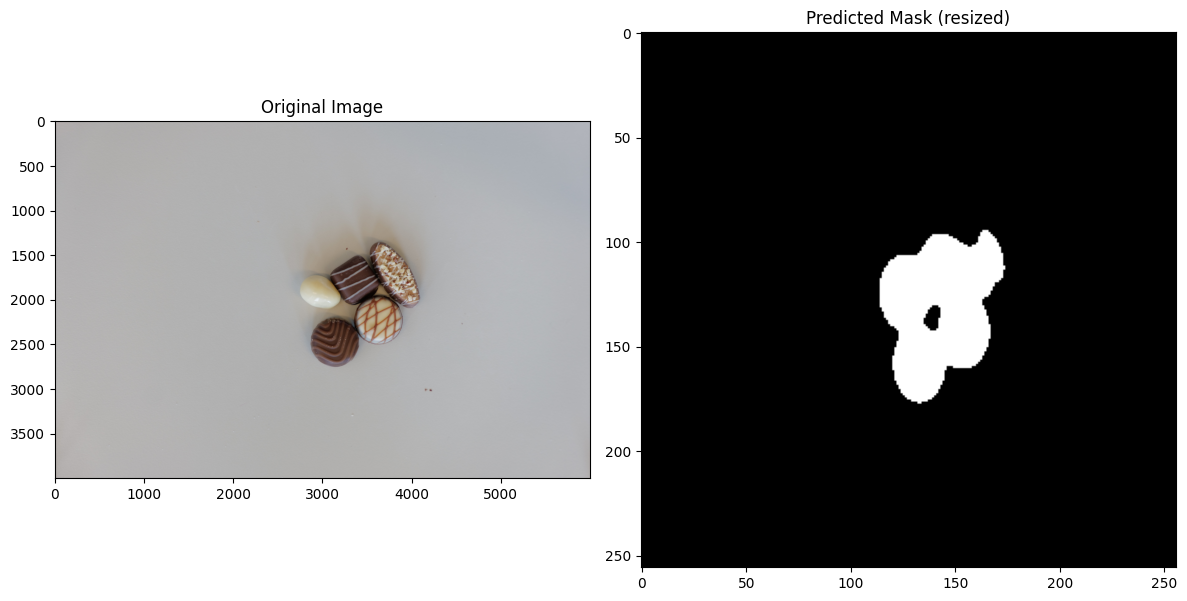

In [103]:
# Replace with your test image path
test_image_path = "dataset_project_iapr2025/test/L1000801.JPG"


# Inference
image_tensor, original_img = load_test_image(test_image_path, size=(256, 256))
predicted_mask = predict_mask(model, image_tensor)
show_result(original_img, predicted_mask)

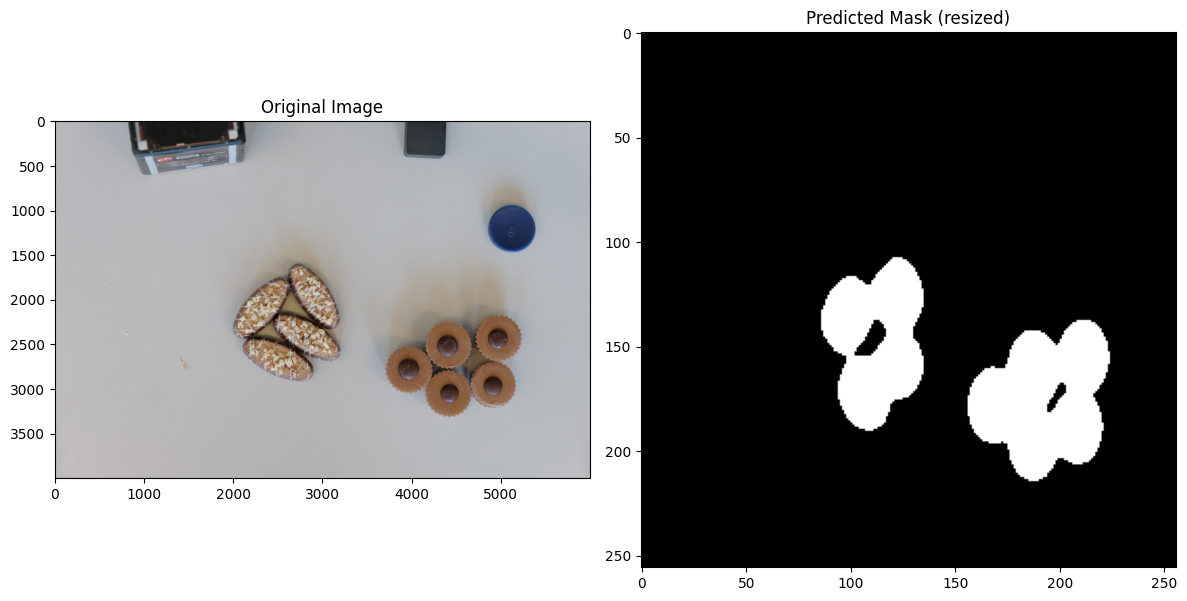

In [104]:
# Replace with your test image path
test_image_path = "dataset_project_iapr2025/test/L1000840.JPG"


# Inference
image_tensor, original_img = load_test_image(test_image_path, size=(256, 256))
predicted_mask = predict_mask(model, image_tensor)
show_result(original_img, predicted_mask)

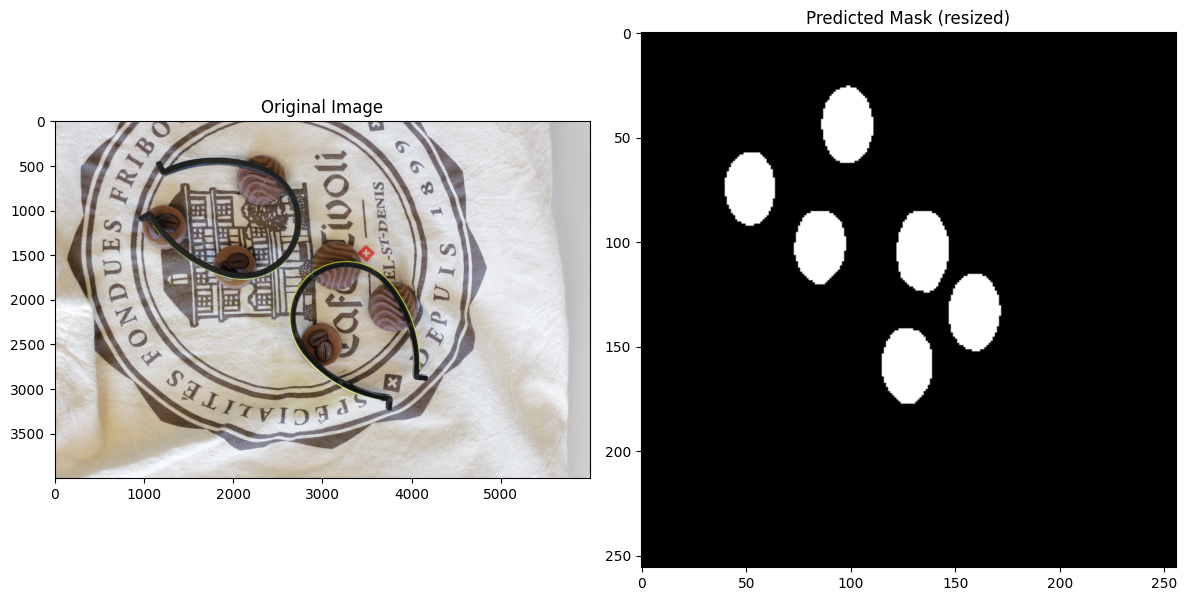

In [105]:

# Replace with your test image path
test_image_path = "dataset_project_iapr2025/test/L1010042.JPG"

# Load model (if starting fresh)
'''model = UNet().to(device)
model.load_state_dict(torch.load("unet_checkpoint.pth", map_location=device))'''

# Inference
image_tensor, original_img = load_test_image(test_image_path, size=(256, 256))
predicted_mask = predict_mask(model, image_tensor)
show_result(original_img, predicted_mask)

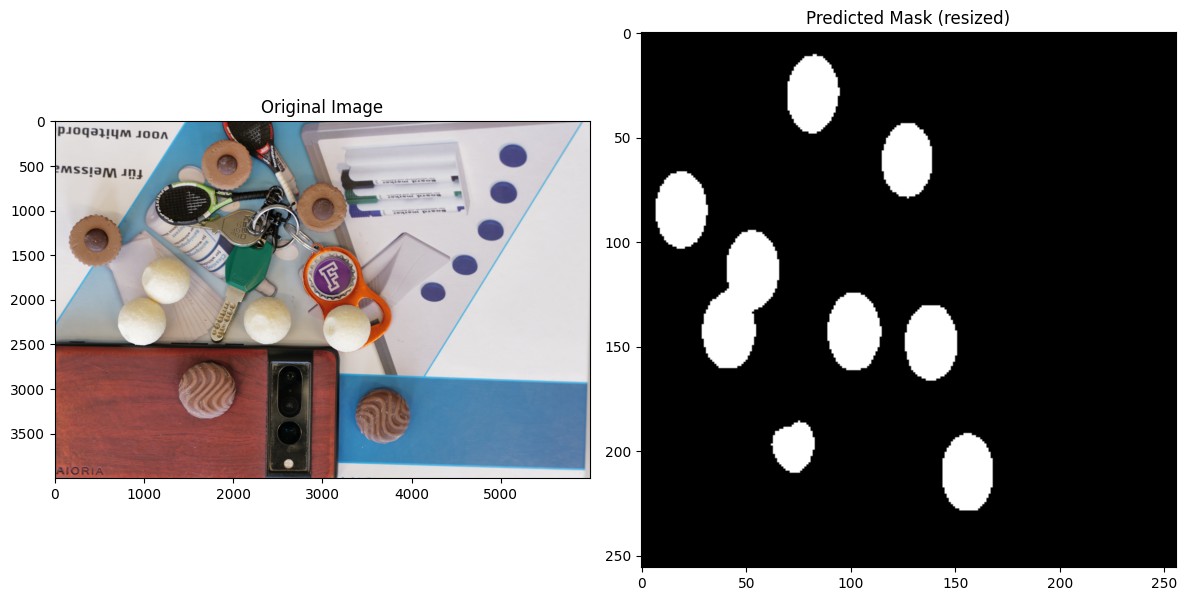

In [106]:

# Replace with your test image path
test_image_path = "dataset_project_iapr2025/test/L1010023.JPG"

# Load model (if starting fresh)
'''model = UNet().to(device)
model.load_state_dict(torch.load("unet_checkpoint.pth", map_location=device))'''

# Inference
image_tensor, original_img = load_test_image(test_image_path, size=(256, 256))
predicted_mask = predict_mask(model, image_tensor)
show_result(original_img, predicted_mask)

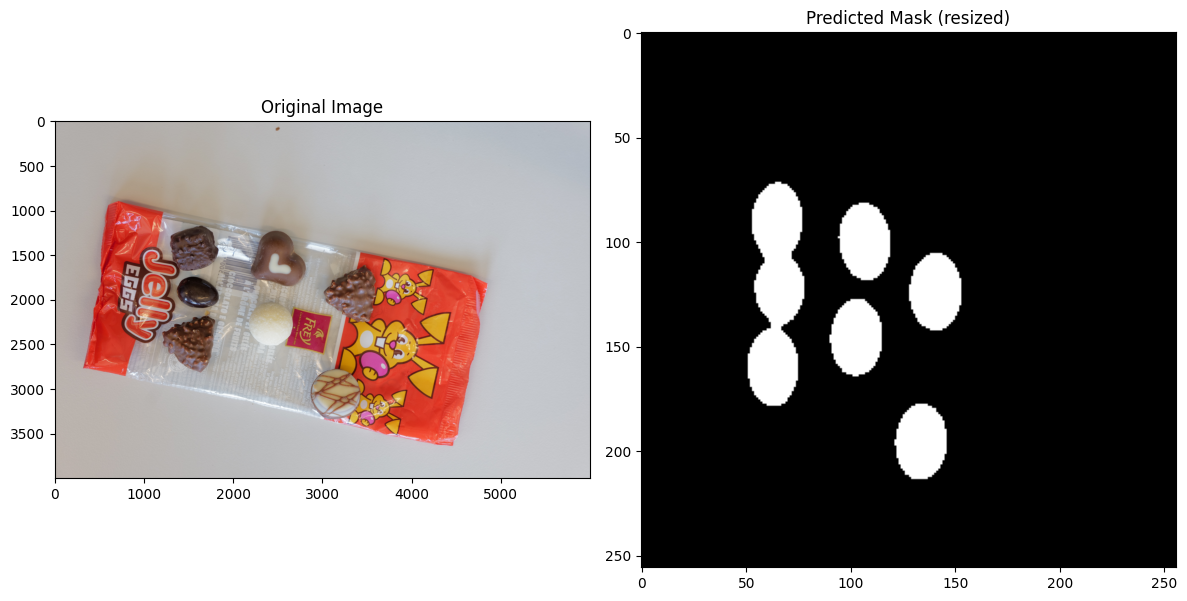

In [107]:
#L1000886
test_image_path = "dataset_project_iapr2025/test/L1000886.JPG"
# Inference
image_tensor, original_img = load_test_image(test_image_path, size=(256, 256))
predicted_mask = predict_mask(model, image_tensor)
show_result(original_img, predicted_mask)

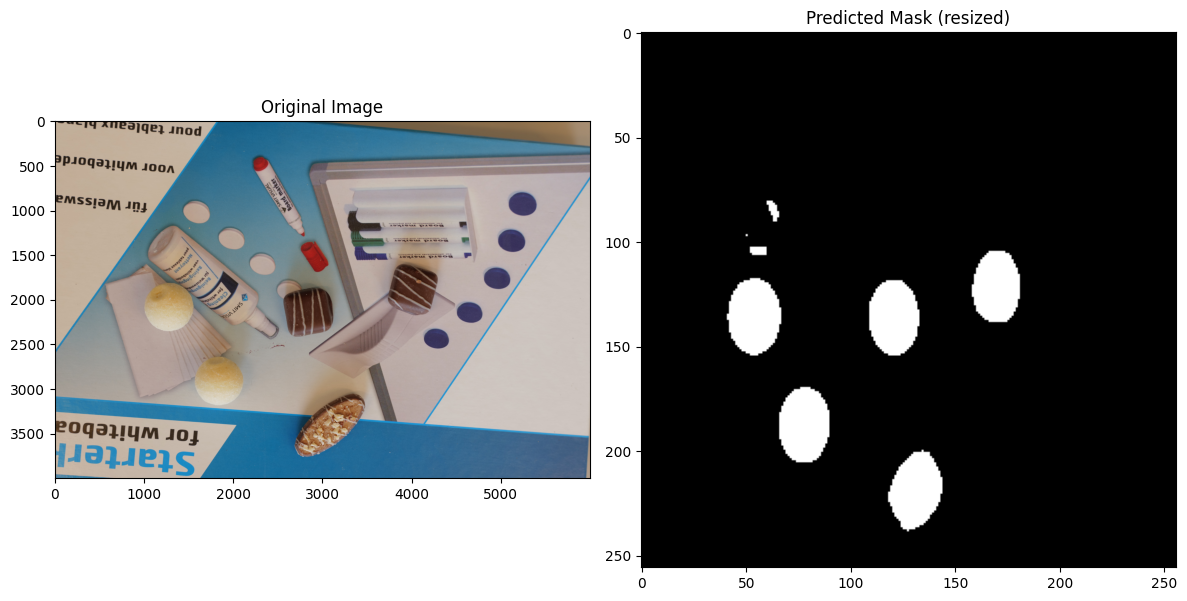

In [108]:
#L1000886
test_image_path = "dataset_project_iapr2025/test/L1000863.JPG"
# Inference
image_tensor, original_img = load_test_image(test_image_path, size=(256, 256))
predicted_mask = predict_mask(model, image_tensor)
show_result(original_img, predicted_mask)

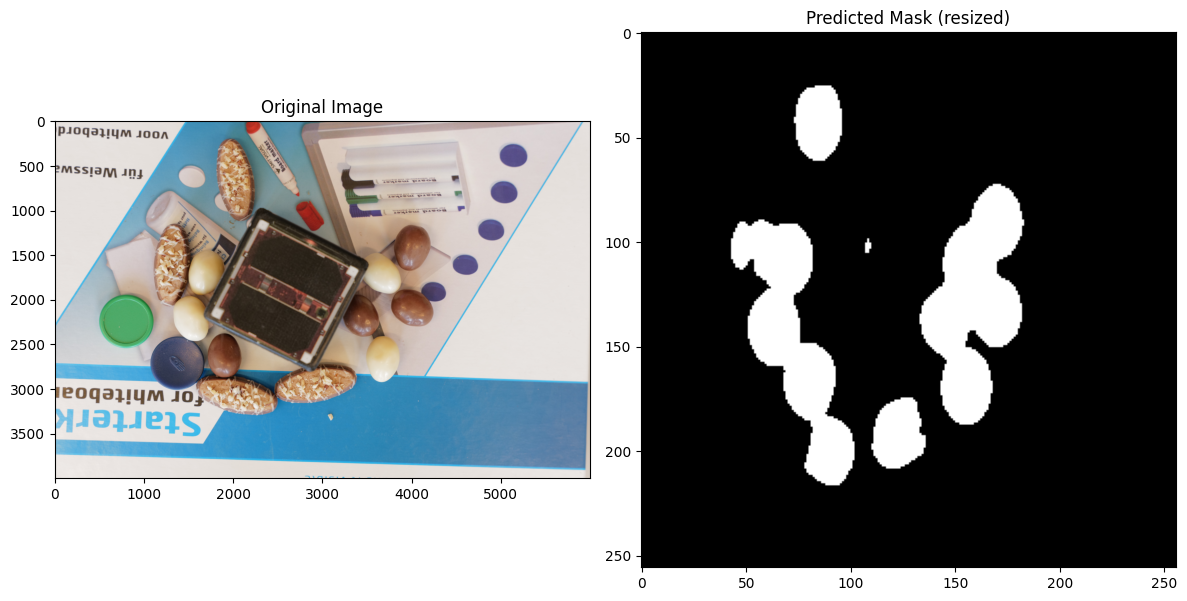

In [109]:
#L1000886
test_image_path = "dataset_project_iapr2025/test/L1010027.JPG"
# Inference
image_tensor, original_img = load_test_image(test_image_path, size=(256, 256))
predicted_mask = predict_mask(model, image_tensor)
show_result(original_img, predicted_mask)

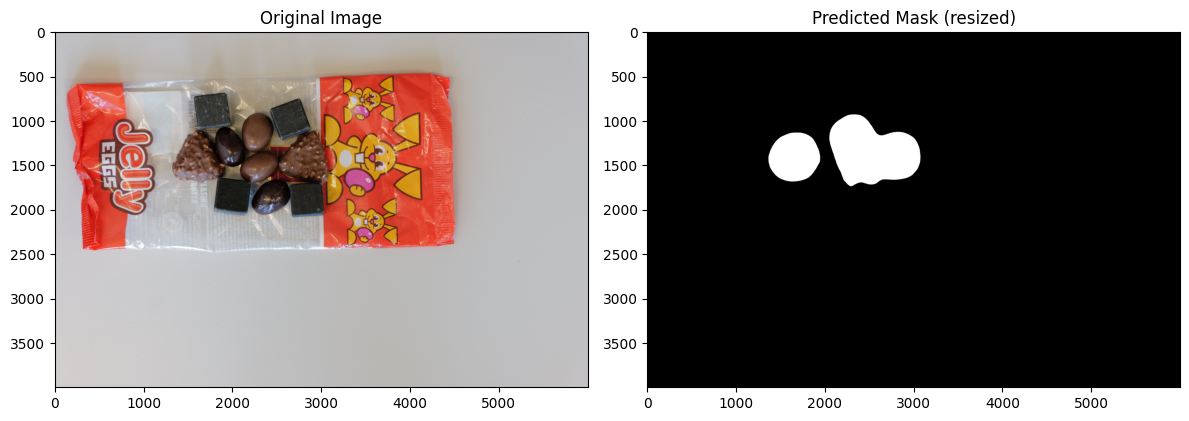

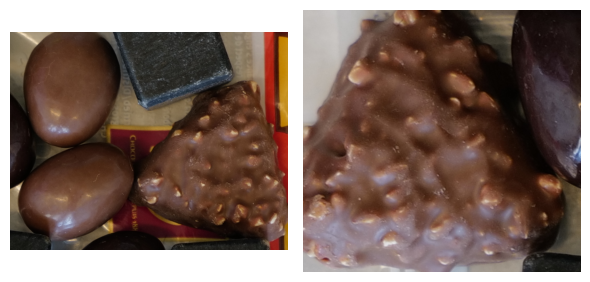

In [73]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
import torchvision.transforms as T
import torchvision.transforms.functional as TF


def extract_chocolate_regions(image: Image.Image, mask: np.ndarray):
    """ Extracts individual chocolate crops from an image using a binary mask. """
    labeled_mask = label(mask)
    props = regionprops(labeled_mask)

    regions = []
    for prop in props:
        y1, x1, y2, x2 = prop.bbox  # bounding box (note order: rows, cols)
        crop = image.crop((x1, y1, x2, y2))
        regions.append((crop, prop.label))  # crop and instance id

    return regions  # list of PIL.Image

def load_test_image(image_path, size=(256, 256)):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor()
    ])
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0)  # [1, 3, H, W]
    return img_tensor.to(device), img  # torch tensor, original PIL image

def predict_mask2(model, image_tensor, original_size):
    model.eval()
    with torch.no_grad():
        pred = model(image_tensor)  # [1, 1, 256, 256]
        pred = pred.squeeze(0)      # [1, 256, 256]
        pred_resized = TF.resize(pred, original_size, antialias=True)  # [1, H, W]
        pred_resized = pred_resized.squeeze(0)  # [H, W]
        binary_mask = (pred_resized > 0.5).cpu().numpy().astype(np.uint8)
    return binary_mask


def show_result(original_img, predicted_mask):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(original_img)
    axs[0].set_title("Original Image")
    axs[1].imshow(predicted_mask, cmap="gray")
    axs[1].set_title("Predicted Mask (resized)")
    plt.tight_layout()
    plt.show()

def extract_chocolate_regions(original_img, mask_np):
    labeled = label(mask_np)
    props = regionprops(labeled)

    crops = []
    for prop in props:
        y1, x1, y2, x2 = prop.bbox
        crop = original_img.crop((x1, y1, x2, y2))  # PIL format
        crops.append(crop)
    return crops

'''def show_crops(crops):
    cols = min(5, len(crops))
    rows = (len(crops) + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
    axs = axs.flatten()
    for i in range(len(crops)):
        axs[i].imshow(crops[i])
        axs[i].axis("off")
    for j in range(len(crops), len(axs)):
        axs[j].axis("off")
    plt.tight_layout()
    plt.show()'''
def show_crops(crops):
    if len(crops) == 1:
        plt.figure(figsize=(3, 3))
        plt.imshow(crops[0])
        plt.axis("off")
        plt.tight_layout()
        plt.show()
        return

    cols = min(5, len(crops))
    rows = (len(crops) + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))

    # Ensure axs is iterable
    axs = np.array(axs).flatten() if isinstance(axs, (np.ndarray, list)) else [axs]

    for i in range(len(crops)):
        axs[i].imshow(crops[i])
        axs[i].axis("off")
    for j in range(len(crops), len(axs)):
        axs[j].axis("off")

    plt.tight_layout()
    plt.show()


# ---------- Run Pipeline ----------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#L1010023
#L1010042
#L1010044
test_image_path = "dataset_project_iapr2025/test/L1010044.JPG"
image_tensor, original_img = load_test_image(test_image_path, size=(256, 256))
original_size = original_img.size[::-1]  # PIL gives (W, H), we want (H, W)

predicted_mask = predict_mask2(model, image_tensor, original_size)

show_result(original_img, predicted_mask)

crops = extract_chocolate_regions(original_img, predicted_mask)
show_crops(crops)

In [ ]:
'''import torch
import torch.nn as nn
import torch.nn.functional as F

class ChocolateCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),  # 3x64x64 -> 16x64x64
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> 16x32x32

            nn.Conv2d(16, 32, 3, padding=1),  # -> 32x32x32
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> 32x16x16
        )
        self.fc = nn.Sequential(
            nn.Linear(32 * 16 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)'''


In [ ]:
'''from torch.utils.data import Dataset
from torchvision import transforms

class ChocolateCropsDataset(Dataset):
    def __init__(self, root_dir, labels_dict, transform=None):
        self.samples = []
        for path, label in labels_dict.items():
            self.samples.append((path, label))
        self.transform = transform or transforms.ToTensor()

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        img = self.transform(img)
        return img, label'''


In [ ]:
'''def predict_chocolate_classes(image: Image.Image, mask: np.ndarray, classifier_model, transform):
    classifier_model.eval()
    regions = extract_chocolate_regions(image, mask)

    predictions = []
    for crop, region_id in regions:
        crop_tensor = transform(crop).unsqueeze(0).to(next(classifier_model.parameters()).device)
        with torch.no_grad():
            pred = classifier_model(crop_tensor)
            label = pred.argmax(dim=1).item()
        predictions.append((region_id, label))

    return predictions
'''

In [ ]:
# Classification

In [ ]:


# 1) DATASET -----------------------------------------------------


# 2) MODEL -------------------------------------------------------


# 3) TRAIN & EVAL -----------------------------------------------


# 4) RUN --------------------------------------------------------




In [ ]:
total_params = sum(p.numel() for p in model.parameters())
total_params

In [ ]:
print(val_loader)